## Imports and Setup

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from lightgbm import LGBMRegressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split



from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import StackingRegressor

import matplotlib.pyplot as plt

from scipy import stats
import numpy as np
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [19]:
preprocessed_dataset = pd.read_csv("../data/pre-processed/preprocessed_youtube_data.csv")

In [20]:
# Convert to datetime if not already
preprocessed_dataset['published_time'] = pd.to_datetime(preprocessed_dataset['published_time'], format='%H:%M:%S', errors='coerce')

# Extract hour and minute
preprocessed_dataset['published_hour'] = preprocessed_dataset['published_time'].dt.hour
preprocessed_dataset['published_minute'] = preprocessed_dataset['published_time'].dt.minute

# Drop the original time column
preprocessed_dataset.drop(columns=['published_time'], inplace=True)

In [22]:
# Separate label encoders for each column
le_day = LabelEncoder()
le_def = LabelEncoder()

preprocessed_dataset['published_day_of_week'] = le_day.fit_transform(preprocessed_dataset['published_day_of_week'])
preprocessed_dataset['definition'] = le_def.fit_transform(preprocessed_dataset['definition'])


In [23]:
missing_mask = preprocessed_dataset[['like_count_initial', 'like_count_final', 'view_count_initial', 'view_count_final']].isnull()

# Check rows where all four columns are NaN
rows_all_nan = missing_mask.all(axis=1)

print("Number of rows with all four columns NaN:", rows_all_nan.sum())

# Optionally, see those rows
print(preprocessed_dataset[rows_all_nan])

Number of rows with all four columns NaN: 15
       category_id  definition  view_count_initial  like_count_initial  \
360            NaN           2                 NaN                 NaN   
414            NaN           2                 NaN                 NaN   
1053           NaN           2                 NaN                 NaN   
1635           NaN           2                 NaN                 NaN   
3221           NaN           2                 NaN                 NaN   
4503           NaN           2                 NaN                 NaN   
8791           NaN           2                 NaN                 NaN   
13543          NaN           2                 NaN                 NaN   
16293          NaN           2                 NaN                 NaN   
17041          NaN           2                 NaN                 NaN   
17227          NaN           2                 NaN                 NaN   
17656          NaN           2                 NaN                 

In [24]:
rows_any_nan = missing_mask.any(axis=1)
print("Rows with any of the four columns NaN:", rows_any_nan.sum())

Rows with any of the four columns NaN: 728


In [25]:
preprocessed_dataset = preprocessed_dataset.dropna(subset=[
    'like_count_initial',
    'like_count_final',
    'view_count_initial',
    'view_count_final'
])

# Define target columns
target_columns = [
    'like_count_initial',
    'like_count_final',
    'view_count_initial',
    'view_count_final'
]

In [26]:
# Choose columns to check for outliers, e.g. target columns
cols_to_check = target_columns  # or other numeric features

z_scores = np.abs(stats.zscore(preprocessed_dataset[cols_to_check]))
# Define threshold, e.g. 3 std deviations
threshold = 3
# Keep only rows where all z-scores are below threshold (no outlier)
non_outliers = (z_scores < threshold).all(axis=1)


print(f"Rows before outlier removal: {len(preprocessed_dataset)}")
preprocessed_dataset = preprocessed_dataset[non_outliers]
print(f"Rows after outlier removal: {len(preprocessed_dataset)}")

Rows before outlier removal: 20613
Rows after outlier removal: 20399


In [27]:
# Separate features and targets
X = preprocessed_dataset.drop(columns=target_columns)
y = preprocessed_dataset[target_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [28]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 14),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'objective': 'reg:squarederror',
        # Remove GPU parameters
        # 'tree_method': 'gpu_hist',
        # 'predictor': 'gpu_predictor',
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = xgb.XGBRegressor(**params)
    try:
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )
    except TypeError:
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='mape',
            verbose=False
        )
    
    preds = model.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, preds)
    return mape

# Run XGBoost optimization
xgb_study = optuna.create_study(direction="minimize", study_name="XGBoost_Optimization")
xgb_study.optimize(xgb_objective, n_trials=100)

print("=== XGBoost Results ===")
print("Best parameters:", xgb_study.best_trial.params)
print("Best MAPE:", xgb_study.best_value)


[I 2025-07-31 09:23:29,591] A new study created in memory with name: XGBoost_Optimization
[I 2025-07-31 09:23:51,515] Trial 0 finished with value: 5.229041078501376e+16 and parameters: {'n_estimators': 3407, 'learning_rate': 0.017452164232145788, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8675408826226205, 'colsample_bytree': 0.6314914246873816, 'gamma': 0.4535791443248611, 'reg_alpha': 0.4919666747876946, 'reg_lambda': 0.8178978417959435}. Best is trial 0 with value: 5.229041078501376e+16.
[I 2025-07-31 09:24:31,994] Trial 1 finished with value: 5.567542912981402e+16 and parameters: {'n_estimators': 2104, 'learning_rate': 0.03969546971652305, 'max_depth': 14, 'min_child_weight': 10, 'subsample': 0.6326387524167948, 'colsample_bytree': 0.9811353055625736, 'gamma': 0.02954028908151929, 'reg_alpha': 0.03542029883235198, 'reg_lambda': 0.2846109303682577}. Best is trial 0 with value: 5.229041078501376e+16.
[I 2025-07-31 09:24:51,224] Trial 2 finished with value: 4.5632292353212

=== XGBoost Results ===
Best parameters: {'n_estimators': 3436, 'learning_rate': 0.16852958414486302, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.9749702309934487, 'colsample_bytree': 0.900592893138114, 'gamma': 0.7640279973538308, 'reg_alpha': 0.6280857040584726, 'reg_lambda': 0.7972579333543999}
Best MAPE: 3.643183245505331e+16


In [29]:
y.shape

(20399, 4)

In [53]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor  # Missing import
from sklearn.metrics import mean_absolute_percentage_error

def lgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 14),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # Remove 'device': 'gpu' to avoid potential issues
        'objective': 'regression',
        'metric': 'mape',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1  # Suppress LightGBM output
    }
    
    base_model = LGBMRegressor(**params)
    model = MultiOutputRegressor(base_model)
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, preds)
    return mape

# Run LightGBM optimization
lgb_study = optuna.create_study(direction="minimize", study_name="LightGBM_Optimization")
lgb_study.optimize(lgb_objective, n_trials=100)

print("=== LightGBM Results ===")
print("Best parameters:", lgb_study.best_trial.params)
print("Best MAPE:", lgb_study.best_value)


[I 2025-07-31 11:41:22,123] A new study created in memory with name: LightGBM_Optimization
[I 2025-07-31 11:42:13,771] Trial 0 finished with value: 6.97576428923912e+16 and parameters: {'n_estimators': 2704, 'learning_rate': 0.132580089010589, 'max_depth': 13, 'reg_alpha': 0.44908985166857807, 'reg_lambda': 0.4491080576584009, 'min_child_samples': 48, 'colsample_bytree': 0.9614506303560031, 'subsample': 0.7532815599323142}. Best is trial 0 with value: 6.97576428923912e+16.
[I 2025-07-31 11:42:33,411] Trial 1 finished with value: 5.4345317339369736e+16 and parameters: {'n_estimators': 1170, 'learning_rate': 0.0987804191997791, 'max_depth': 7, 'reg_alpha': 0.5155076706917604, 'reg_lambda': 0.651451860032027, 'min_child_samples': 11, 'colsample_bytree': 0.8583078662537464, 'subsample': 0.9475836949999525}. Best is trial 1 with value: 5.4345317339369736e+16.
[I 2025-07-31 11:43:24,018] Trial 2 finished with value: 6.1893159424721096e+16 and parameters: {'n_estimators': 3088, 'learning_rate

In [31]:
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

def catboost_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 4, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 64),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0, 1.0),
        'loss_function': 'MAPE',
        'eval_metric': 'MAPE',
        'random_state': 42,
        # Remove 'task_type': 'GPU' - this is causing the error
        'verbose': False
    }
    
    # For multi-output regression with CatBoost
    base_model = CatBoostRegressor(**params)
    model = MultiOutputRegressor(base_model)
    
    # MultiOutputRegressor doesn't support eval_set and early_stopping_rounds
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, preds)
    return mape

# Run CatBoost optimization
catboost_study = optuna.create_study(direction="minimize", study_name="CatBoost_Optimization")
catboost_study.optimize(catboost_objective, n_trials=100)

print("=== CatBoost Results ===")
print("Best parameters:", catboost_study.best_trial.params)
print("Best MAPE:", catboost_study.best_value)


[I 2025-07-31 10:21:27,906] A new study created in memory with name: CatBoost_Optimization
[I 2025-07-31 10:21:48,553] Trial 0 finished with value: 1605228674321080.2 and parameters: {'n_estimators': 3109, 'learning_rate': 0.11841832086227236, 'depth': 5, 'min_data_in_leaf': 29, 'l2_leaf_reg': 7.286375834691979, 'bagging_temperature': 0.09893764899391289, 'random_strength': 0.37952510772056514}. Best is trial 0 with value: 1605228674321080.2.
[I 2025-07-31 10:22:46,106] Trial 1 finished with value: 3.102282802369495e+16 and parameters: {'n_estimators': 3022, 'learning_rate': 0.12746094882318437, 'depth': 10, 'min_data_in_leaf': 24, 'l2_leaf_reg': 1.6882564424410162, 'bagging_temperature': 0.4200638129151042, 'random_strength': 0.02768461433463898}. Best is trial 0 with value: 1605228674321080.2.
[I 2025-07-31 10:23:06,940] Trial 2 finished with value: 1835073306661921.8 and parameters: {'n_estimators': 3178, 'learning_rate': 0.12625246990136232, 'depth': 5, 'min_data_in_leaf': 47, 'l2_

=== CatBoost Results ===
Best parameters: {'n_estimators': 664, 'learning_rate': 0.044649673512359954, 'depth': 4, 'min_data_in_leaf': 42, 'l2_leaf_reg': 7.02374553841955, 'bagging_temperature': 0.5472300441902748, 'random_strength': 0.7146214581056887}
Best MAPE: 191925869144157.66


In [32]:
results = {
    'XGBoost': xgb_study.best_value,
    'LightGBM': lgb_study.best_value,
    'CatBoost': catboost_study.best_value
}

print("\n=== Final Comparison ===")
for model_name, best_mape in results.items():
    print(f"{model_name}: {best_mape:.6f}")

best_model = min(results, key=results.get)
print(f"\nBest performing model: {best_model} with MAPE: {results[best_model]:.6f}")


=== Final Comparison ===
XGBoost: 36431832455053312.000000
LightGBM: 49176027987689856.000000
CatBoost: 191925869144157.656250

Best performing model: CatBoost with MAPE: 191925869144157.656250


In [33]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Any NaN values in targets:", y_train.isnull().sum().sum())


Training set shape: (16319, 17) (16319, 4)
Validation set shape: (4080, 17) (4080, 4)
Any NaN values in targets: 0


In [38]:
xgb_model = xgb.XGBRegressor(**xgb_study.best_trial.params)
                             

In [39]:
lgbm_model = LGBMRegressor(**lgb_study.best_trial.params)


In [40]:
catboost_model = CatBoostRegressor(**catboost_study.best_trial.params)

In [41]:
xgb_model2 = MultiOutputRegressor(xgb_model)
xgb_model2.fit(X_train, y_train)
preds =xgb_model2.predict(X_valid)
overall_mae = mean_absolute_error(y_valid, preds)
print("Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")

# Manual MAPE calculation to debug
# manual_mape = np.mean(np.abs((y_valid - preds) / y_valid)) * 100
# print("Manual MAPE:", manual_mape)


Overall MAE: 337.577880859375

MAE for each output column:
Column 0: 21.1430
Column 1: 22.2411
Column 2: 636.5181
Column 3: 670.4094


In [42]:
lgbm_model2 = MultiOutputRegressor(lgbm_model)
lgbm_model2.fit(X_train, y_train)
preds =lgbm_model2.predict(X_valid)
overall_mae = mean_absolute_error(y_valid, preds)
print("Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")

Overall MAE: 345.0484313959246

MAE for each output column:
Column 0: 21.5697
Column 1: 22.3167
Column 2: 643.6763
Column 3: 692.6309


In [43]:
catboost_model2 = MultiOutputRegressor(catboost_model)
catboost_model2.fit(X_train, y_train)
preds =catboost_model2.predict(X_valid)
overall_mae = mean_absolute_error(y_valid, preds)
print("Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")

0:	learn: 145.4496709	total: 2.02ms	remaining: 1.34s
1:	learn: 143.3049898	total: 3.13ms	remaining: 1.04s
2:	learn: 141.3132315	total: 4.01ms	remaining: 884ms
3:	learn: 139.4226314	total: 5ms	remaining: 825ms
4:	learn: 137.5830180	total: 5.96ms	remaining: 786ms
5:	learn: 135.8490016	total: 6.97ms	remaining: 765ms
6:	learn: 134.2966710	total: 8.1ms	remaining: 760ms
7:	learn: 132.7952622	total: 8.98ms	remaining: 736ms
8:	learn: 131.4094441	total: 9.81ms	remaining: 714ms
9:	learn: 130.0327942	total: 10.8ms	remaining: 704ms
10:	learn: 128.6918515	total: 11.7ms	remaining: 693ms
11:	learn: 127.3656149	total: 12.6ms	remaining: 683ms
12:	learn: 126.1777918	total: 13.4ms	remaining: 672ms
13:	learn: 125.0150203	total: 14.9ms	remaining: 692ms
14:	learn: 123.9823066	total: 15.8ms	remaining: 685ms
15:	learn: 122.8804051	total: 16.6ms	remaining: 673ms
16:	learn: 121.9499441	total: 17.6ms	remaining: 670ms
17:	learn: 121.0433081	total: 18.4ms	remaining: 661ms
18:	learn: 120.2058131	total: 19.3ms	remai

In [44]:
meta_model = LinearRegression()

In [45]:
stacking_model2 = StackingRegressor(
    estimators=[
        ('xgb', xgb_model), 
        ('lgb', lgbm_model), 
        ('catboost', catboost_model)
    ],
    final_estimator=meta_model,
    n_jobs=-1

)
stacking_model2 = MultiOutputRegressor(stacking_model2)
# stacking_model2.fit(X_scaled, y)

In [46]:
stacking_model2.fit(X_train, y_train)
preds =stacking_model2.predict(X_valid)
overall_mae = mean_absolute_error(y_valid, preds)
print("Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 16319, number of used features: 15
[LightGBM] [Info] Start training from score 33.251241
0:	learn: 145.4496709	total: 58.2ms	remaining: 38.6s
1:	learn: 143.3049898	total: 59.3ms	remaining: 19.6s
2:	learn: 141.3132315	total: 60.4ms	remaining: 13.3s
3:	learn: 139.4226314	total: 61.5ms	remaining: 10.2s
4:	learn: 137.5830180	total: 62.8ms	remaining: 8.28s
5:	learn: 135.8490016	total: 63.8ms	remaining: 6.99s
6:	learn: 134.2966710	total: 64.9ms	remaining: 6.09s
7:	learn: 132.7952622	total: 66.2ms	remaining: 5.43s
8:	learn: 131.4094441	total: 67.3ms	remaining: 4.9s
9:	learn: 130.0327942	total: 68.4ms	remaining: 4.47s
10:	learn: 128.6918515	total: 70.5ms	remaining: 4.18s
11:	learn: 127.3656149	total: 71.5ms	remaining: 3.88s
12:	learn: 126.17779

In [47]:
# 1. Create a blend split from training data
X_base, X_blend, y_base, y_blend = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. Wrap models in MultiOutputRegressor
xgb_model_blend = MultiOutputRegressor(xgb_model)
lgbm_model_blend = MultiOutputRegressor(lgbm_model)
catboost_model_blend = MultiOutputRegressor(catboost_model)

# 3. Train base models on base set
xgb_model_blend.fit(X_base, y_base)
lgbm_model_blend.fit(X_base, y_base)
catboost_model_blend.fit(X_base, y_base)

0:	learn: 145.4496709	total: 1.88ms	remaining: 1.24s
1:	learn: 143.3049898	total: 2.89ms	remaining: 957ms
2:	learn: 141.3132315	total: 3.66ms	remaining: 806ms
3:	learn: 139.4226314	total: 4.45ms	remaining: 735ms
4:	learn: 137.5830180	total: 5.36ms	remaining: 706ms
5:	learn: 135.8490016	total: 6.21ms	remaining: 681ms
6:	learn: 134.2966710	total: 7.03ms	remaining: 660ms
7:	learn: 132.7952622	total: 7.91ms	remaining: 648ms
8:	learn: 131.4094441	total: 8.71ms	remaining: 634ms
9:	learn: 130.0327942	total: 9.52ms	remaining: 623ms
10:	learn: 128.6918515	total: 10.3ms	remaining: 611ms
11:	learn: 127.3656149	total: 11.1ms	remaining: 601ms
12:	learn: 126.1777918	total: 11.9ms	remaining: 595ms
13:	learn: 125.0150203	total: 12.7ms	remaining: 590ms
14:	learn: 123.9823066	total: 13.5ms	remaining: 583ms
15:	learn: 122.8804051	total: 14.2ms	remaining: 575ms
16:	learn: 121.9499441	total: 15.7ms	remaining: 599ms
17:	learn: 121.0433081	total: 16.5ms	remaining: 593ms
18:	learn: 120.2058131	total: 17.2ms	r

,estimator,<catboost.cor...t 0x12fbdf4a0>
,n_jobs,None


In [48]:
# 4. Predict on blend set to create meta features
xgb_preds_blend = xgb_model_blend.predict(X_blend)
lgbm_preds_blend = lgbm_model_blend.predict(X_blend)
catboost_preds_blend = catboost_model_blend.predict(X_blend)

# 5. Stack base model predictions horizontally for meta input
X_meta_blend = np.hstack([xgb_preds_blend, lgbm_preds_blend, catboost_preds_blend])

# 6. Train meta-model on blend predictions
meta_model_blend = MultiOutputRegressor(LinearRegression())
meta_model_blend.fit(X_meta_blend, y_blend)

# 7. Predict on validation set using base models
xgb_preds_valid = xgb_model_blend.predict(X_valid)
lgbm_preds_valid = lgbm_model_blend.predict(X_valid)
catboost_preds_valid = catboost_model_blend.predict(X_valid)




In [49]:
# 8. Stack base predictions for final meta input
X_meta_valid = np.hstack([xgb_preds_valid, lgbm_preds_valid, catboost_preds_valid])

# 9. Final prediction from meta-model
final_preds = meta_model_blend.predict(X_meta_valid)

# 10. Evaluate
overall_mae = mean_absolute_error(y_valid, final_preds)
print("🔁 Blending - Overall MAE:", overall_mae)

print("\nMAE for each output column:")
for col_idx in range(y_valid.shape[1]):
    col_mae = mean_absolute_error(y_valid.iloc[:, col_idx], final_preds[:, col_idx])
    print(f"Column {col_idx}: {col_mae:.4f}")

🔁 Blending - Overall MAE: 296.89763416720064

MAE for each output column:
Column 0: 20.6114
Column 1: 21.4775
Column 2: 553.4207
Column 3: 592.0809


In [50]:
# Store MAEs for each model
model_maes = {
    "XGBoost": [mean_absolute_error(y_valid.iloc[:, i], xgb_model2.predict(X_valid)[:, i]) for i in range(y.shape[1])],
    "LightGBM": [mean_absolute_error(y_valid.iloc[:, i], lgbm_model2.predict(X_valid)[:, i]) for i in range(y.shape[1])],
    "CatBoost": [mean_absolute_error(y_valid.iloc[:, i], catboost_model2.predict(X_valid)[:, i]) for i in range(y.shape[1])],
    "Stacking": [mean_absolute_error(y_valid.iloc[:, i], stacking_model2.predict(X_valid)[:, i]) for i in range(y.shape[1])],
    "Blending": [mean_absolute_error(y_valid.iloc[:, i], final_preds[:, i]) for i in range(y.shape[1])]
}

target_names = y.columns.tolist()


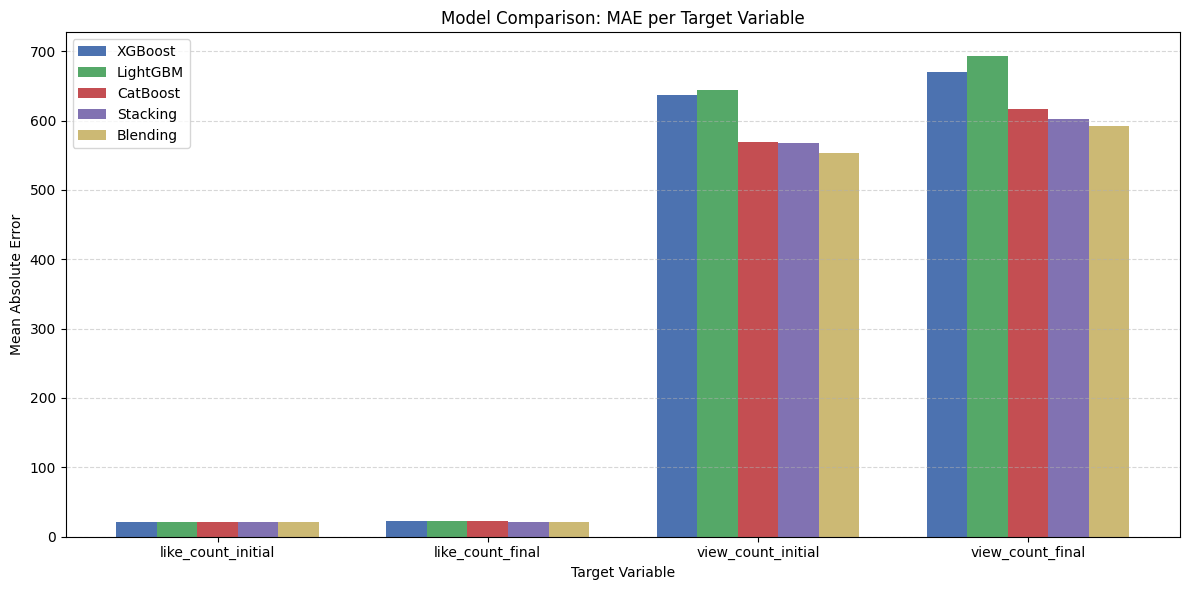

In [51]:
# Setup
bar_width = 0.15
index = np.arange(len(target_names))

# Plot
plt.figure(figsize=(12, 6))

colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
for i, (model_name, mae_list) in enumerate(model_maes.items()):
    plt.bar(index + i * bar_width, mae_list, bar_width, label=model_name, color=colors[i])

# Labels & ticks
plt.xlabel('Target Variable')
plt.ylabel('Mean Absolute Error')
plt.title('Model Comparison: MAE per Target Variable')
plt.xticks(index + bar_width * 2, target_names)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

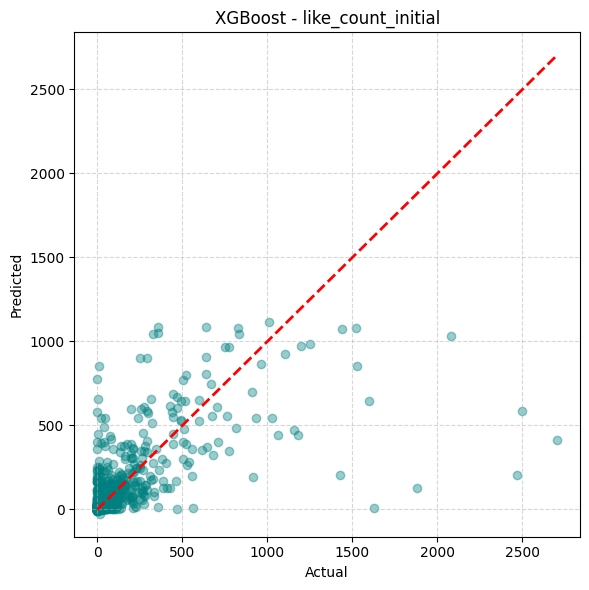

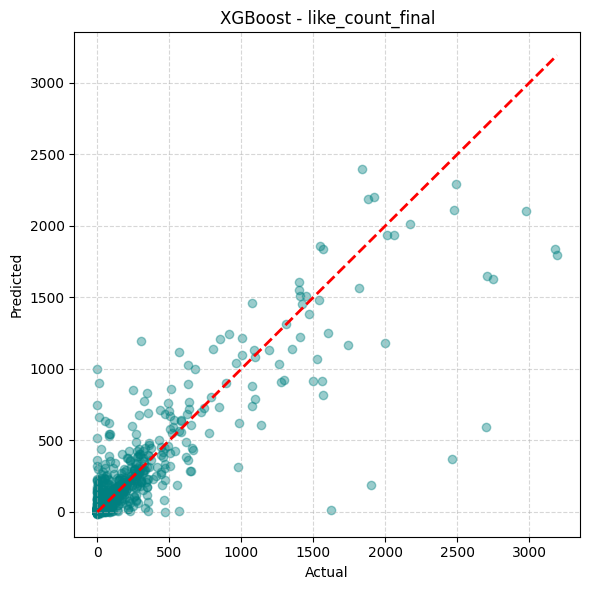

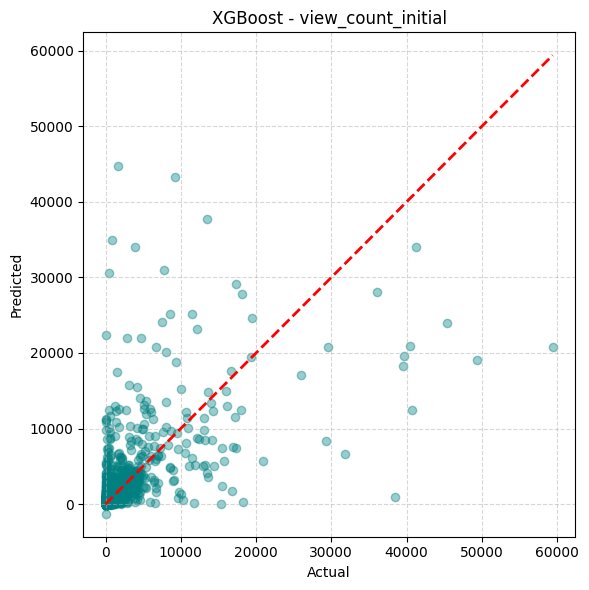

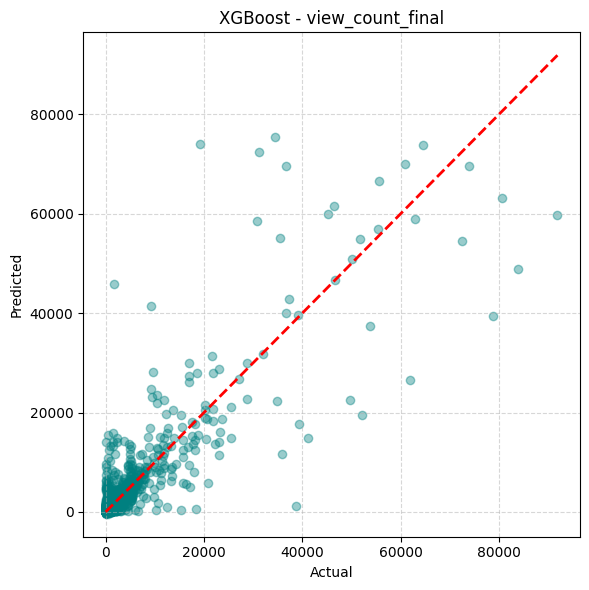

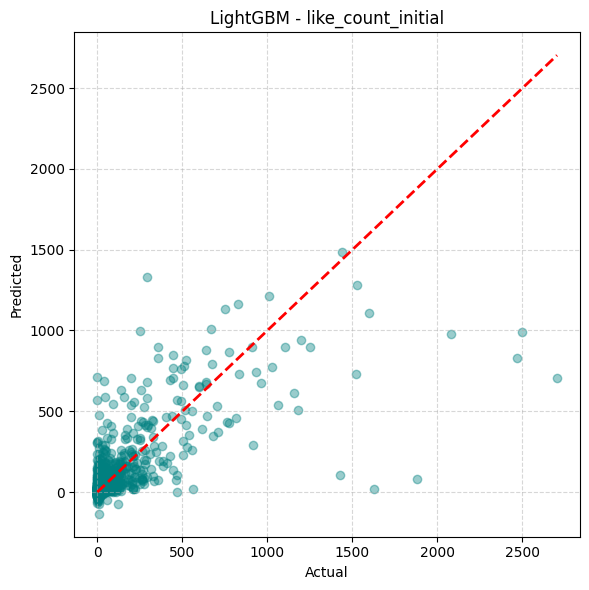

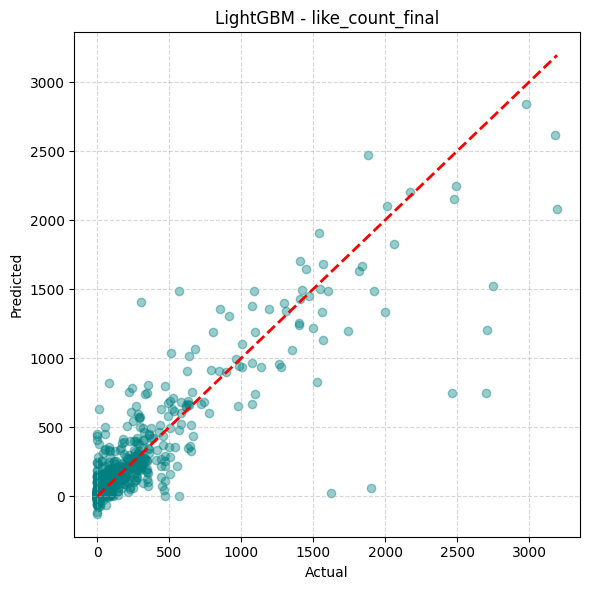

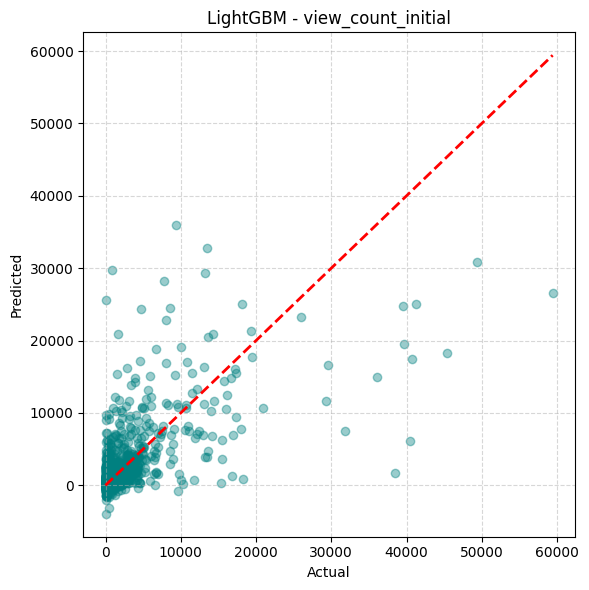

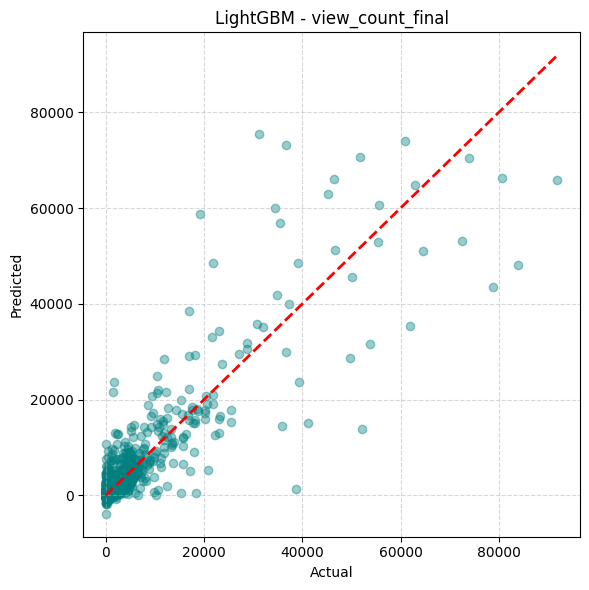

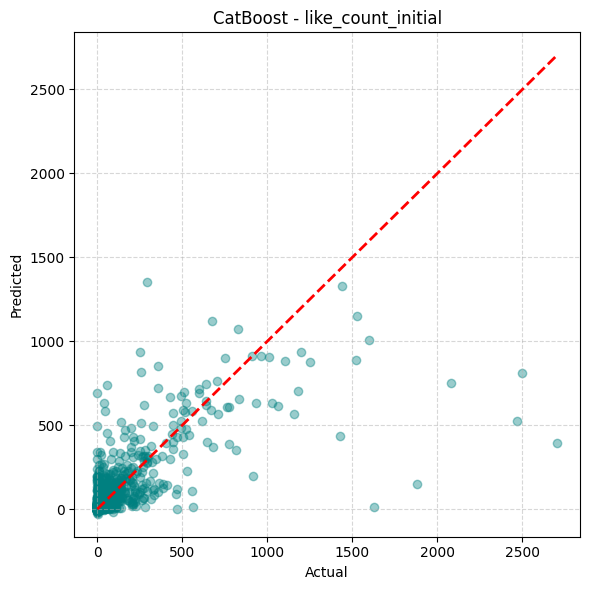

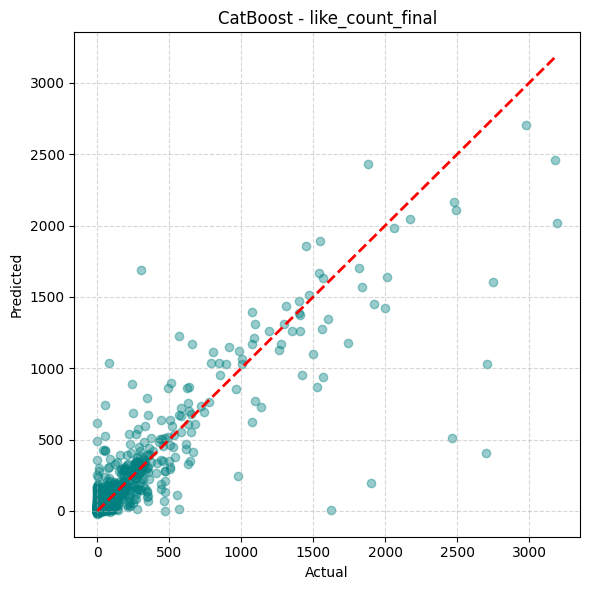

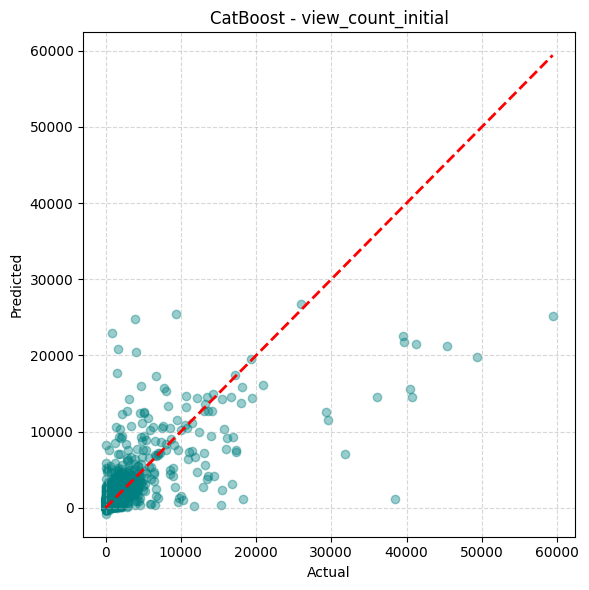

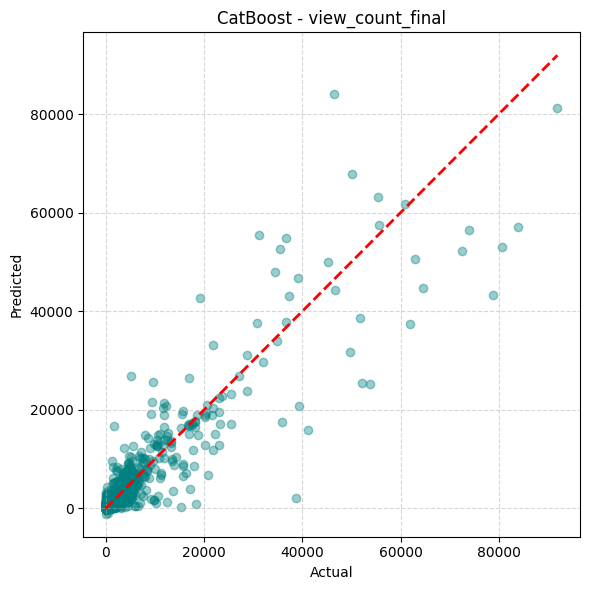

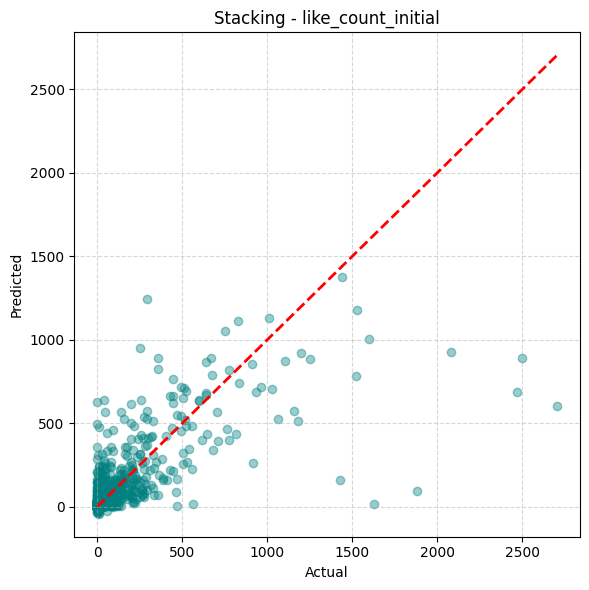

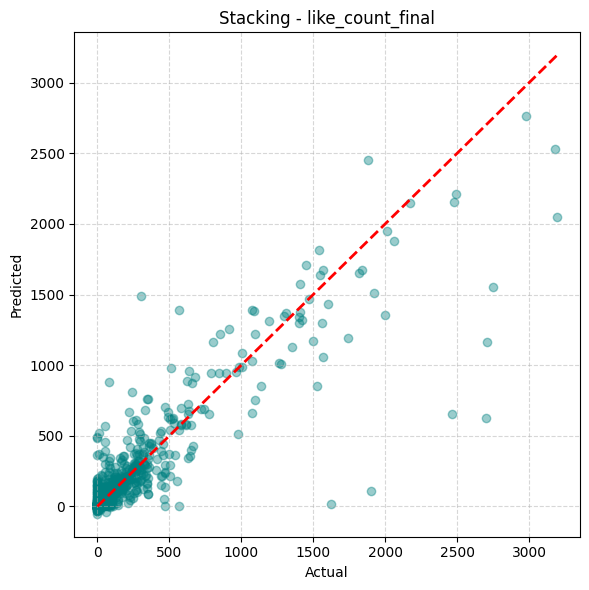

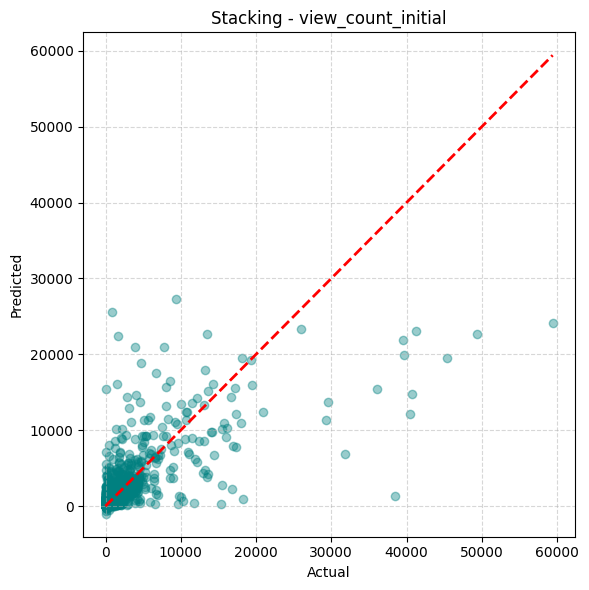

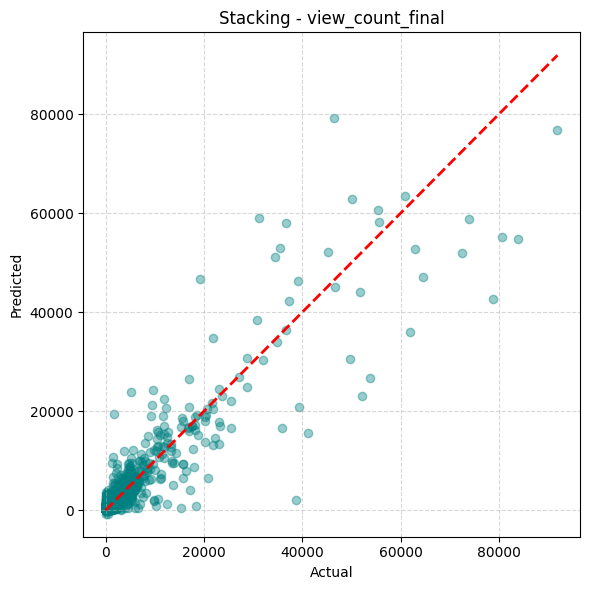

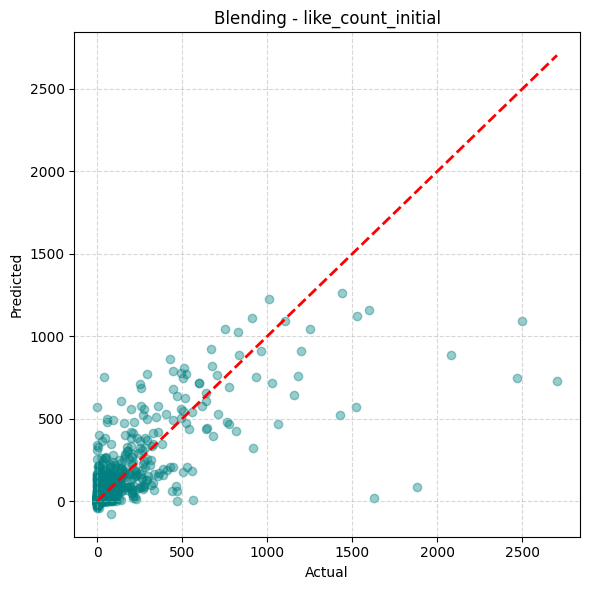

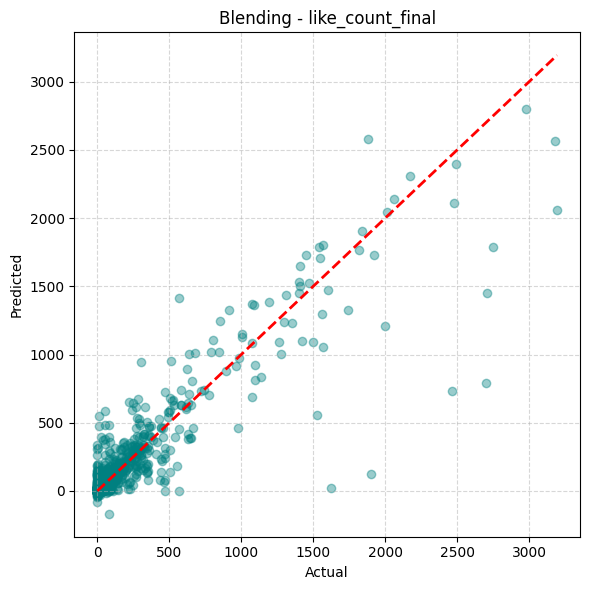

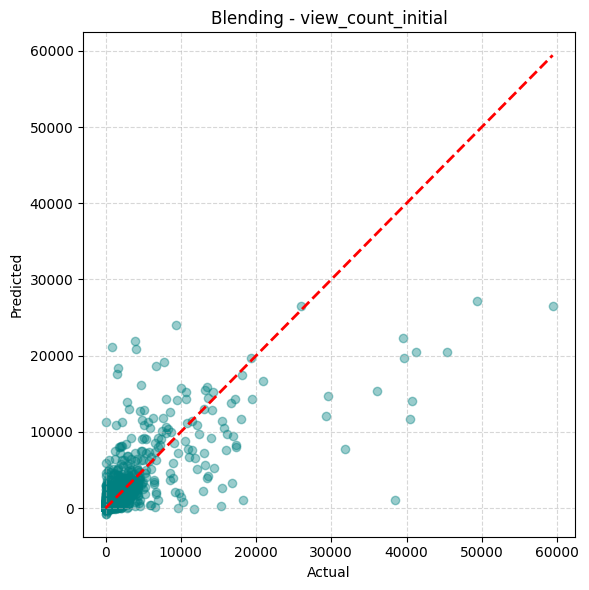

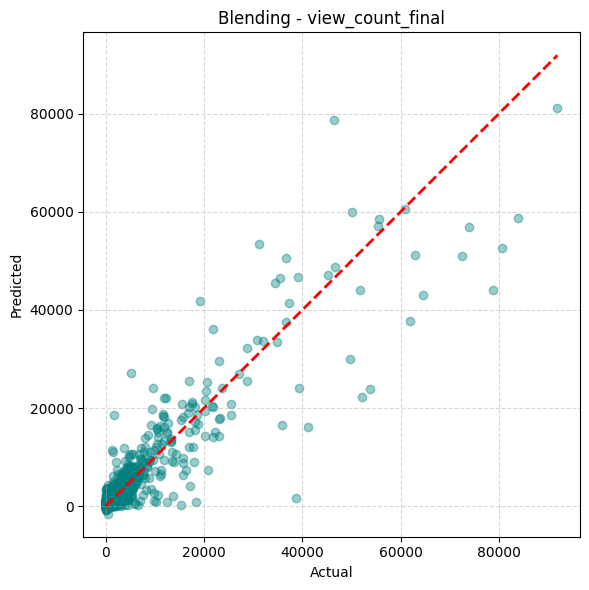

In [52]:
# Models and their predictions
model_preds = {
    "XGBoost": xgb_model2.predict(X_valid),
    "LightGBM": lgbm_model2.predict(X_valid),
    "CatBoost": catboost_model2.predict(X_valid),
    "Stacking": stacking_model2.predict(X_valid),
    "Blending": final_preds  # from your blending step
}

n_targets = y.shape[1]
target_names = y.columns.tolist()

# Plot
for model_name, preds in model_preds.items():
    for i in range(n_targets):
        plt.figure(figsize=(6, 6))
        plt.scatter(y_valid.iloc[:, i], preds[:, i], alpha=0.4, color='teal')
        plt.plot([y_valid.iloc[:, i].min(), y_valid.iloc[:, i].max()],
                 [y_valid.iloc[:, i].min(), y_valid.iloc[:, i].max()],
                 'r--', lw=2)  # y = x line

        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{model_name} - {target_names[i]}")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Save figure
        filename = f"../images/{model_name}_{target_names[i]}.png".replace(" ", "_")
        plt.savefig(filename)
        plt.close()  # Close the figure to save memory